# Tutorial 6 - Condenser numerical aperture

Welcome to the sixth tutorial of this series!
In this notebook, we'll investigate the effect of the condenser numerical aperture on the structure function.

### Purpose

The goal of this tutorial is to demonstrate the effect of the condenser numerical aperture on the results obtained by DDM.
Specifically, we will:

0. Set up the workspace and import the libraries
    1. Set up the workspace.
    2. Give an overview of the sample under investigation.
    3. Import libraries.
1. Compute the structure function of image sequences using DDM.
    1. Load the image sequences and see the effect of different condenser numerical apertures on the input images.
    2. Calculate the corresponding structure functions.
    3. Calculate the azimuthal averages.
2. Fit the azimuthal average to gain insights into the sample's dynamics.
    1. Estimate the parameters.
    2. Fit the data using a diffusive dynamics model.
    3. Observe the effect of the condenser numerical aperture on the output of the technique.
    4. Fit the parameters obtained from the fit to the data to retrieve the diffusion coefficient of the particles.
3. Investigate the dependence of the amplitude on the experimental parameters.
    1. Outline the analytical formula for the amplitude.
    2. Fit the data obtained.

This tutorial assumes that you have a basic understanding of the features offered by fastDDM. If you need a refresher, consider reviewing the ["zeroth" tutorial](../Tutorial_0-Introduction/tutorial0.ipynb).
It also builds on top of the previous tutorials [1](../Tutorial_1-Particle_sizing/tutorial1.ipynb) and [2](../Tutorial_2-Melt/tutorial2.ipynb).

At the end of the notebook, there will be an optional (starred) section:

* (*): Figures for the condenser numerical aperture section of the paper.

## 0. Initial setup

### 0.A. Setting up your workspace

Before we dive into the analysis, make sure you have **fastDDM** and the required scientific analysis, fitting, and visualization packages installed on your machine. Refer to the main [README](../README.md) for installation instructions.

For this tutorial, we'll be using custom microscopy videos acquired for these tutorials.
If you haven't done so already, download the files (the `DATASET` folder) available on Phaidra (https://doi.org/10.25365/phaidra.686).

Your main directory tree should resemble the following:
```
.
├── DATASET
│   └── ...
├── Tutorial_6-Condenser_na
└── ...
```

### 0.B. Sample description and experimental parameters

The sample under study consists of a dilute solution of polystyrene spheres (PS, nominal diameter 252 nm, Microparticles GmbH) dispersed in a glycerol aqueous solution ($c_{\text{gly}} = 21.5\%$) to prevent sedimentation.
The sample was prepared at a volume fraction $\phi=10^{-4}$ and loaded into a 0.3 $\times$ 3 $\times$ 50 mm glass capillary (Vitrocom).
The experiments were performed at $T \simeq 21^{\circ}\mathrm{C}$ (solvent viscosity $\eta = 1.78 \, \mathrm{mPa \, s}$).

The videos were acquired at 111 and 1 fps for the fast and slow acquisition, respectively, using a Nikon Eclipse Ti2 inverted microscope equipped with an ORCA-Flash4.0 V3 CMOS camera (pixel size $6.5 \, \mathrm{µm}$).
Each set of videos was acquired using a 20$\times$, NA 0.7 objective, giving an effective pixel size of 325 nm.
We tuned the condenser iris to achieve different condenser numerical apertures, roughly 0.037, 0.1, 0.18, and 0.3 (the nominal condenser NA).
To illuminate the sample, we selected the blue LED of the installed lamp (LIDA Lumencor).
The image sequences are composed of 10000 frames each, 512$\times$512 pixels.

### 0.C. Let's get started

Let's import some essential libraries, including `fastDDM`.

In [1]:
%matplotlib inline

import gc
import os
import lmfit
import numpy as np

# set numpy print options to limit the length of the output
np.set_printoptions(threshold=0)

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

# get rid of the 'too many open images' warning
mpl.rcParams.update({'figure.max_open_warning': 0,
                     'figure.dpi': 300})

# color space helper
def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

# fastddm
import fastddm as fd
from fastddm.fit import fit

Here, we define the paths to the videos and the labels.

In [2]:
# directory containing the videos
main_directory = '../DATASET/'

# high frame rate videos file names (including enclosing folder)
file_names_fast = [
    'PS_252nm_phi_1e-4_20x_NA_0-7_cond-NA_0p_led_blue/fast.nd2',
    'PS_252nm_phi_1e-4_20x_NA_0-7_cond-NA_25p_led_blue/fast.nd2',
    'PS_252nm_phi_1e-4_20x_NA_0-7_cond-NA_50p_led_blue/fast.nd2',
    'PS_252nm_phi_1e-4_20x_NA_0-7_cond-NA_100p_led_blue/fast.nd2',
]

# create full paths
file_paths_fast = [
    os.path.join(main_directory, fn) for fn in file_names_fast
]

# low frame rate videos file names (including enclosing folder)
file_names_slow = [
    'PS_252nm_phi_1e-4_20x_NA_0-7_cond-NA_0p_led_blue/slow.nd2',
    'PS_252nm_phi_1e-4_20x_NA_0-7_cond-NA_25p_led_blue/slow.nd2',
    'PS_252nm_phi_1e-4_20x_NA_0-7_cond-NA_50p_led_blue/slow.nd2',
    'PS_252nm_phi_1e-4_20x_NA_0-7_cond-NA_100p_led_blue/slow.nd2',
]

# create full paths
file_paths_slow = [
    os.path.join(main_directory, fn) for fn in file_names_slow
]

# list of labels
labels = [
    r'NA$_c$ 0.037',
    r'NA$_c$ 0.1',
    r'NA$_c$ 0.18',
    r'NA$_c$ 0.3',
]

## 1. Structure function calculation

### 1.A. Load and visualize images

As usual, we start by inspecting the image sequences.
We show the first frame of the fast videos side by side.

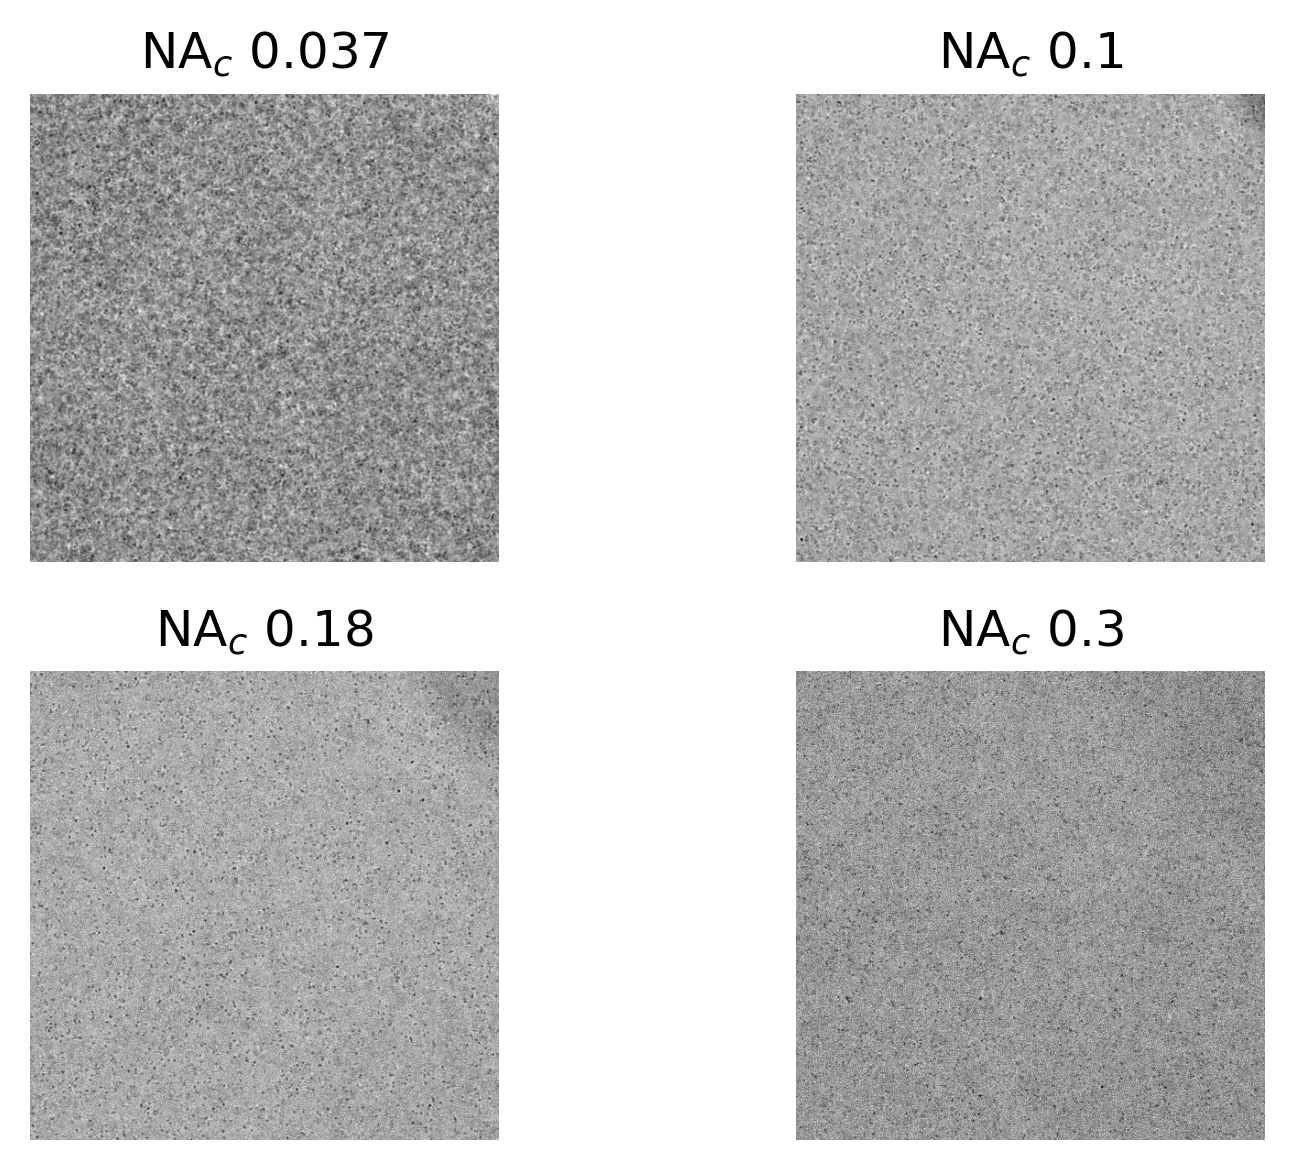

In [3]:
fig = plt.figure()
gs = fig.add_gridspec(ncols=2, nrows=2)
axs = gs.subplots()

# read the images
images = [fd.read_images(fp, seq=[0])[0] for fp in file_paths_fast]
images = np.array(images)

for ax, img, label in zip(axs.flatten(), images, labels):
    ax.imshow(img, cmap='gray')
    
    ax.set_axis_off()
    ax.set_title(label)

fig.tight_layout();

Decreasing the numerical aperture of the condenser increases the signal coming from the suspended objects.

### 1.B-C. Structure function and azimuthal average calculation

The process here mirrors the one outlined in [tutorial2](../Tutorial_2-Melt/tutorial2.ipynb).
Use the following cell to select the `core` and `mode` you wish to use for the calculation of the structure function.

In [4]:
### UNCOMMENT THE CORE YOU WISH TO USE ###
CORE = 'py'
#CORE = 'cpp'
#CORE = 'cuda'

### UNCOMMENT THE MODE YOU WISH TO USE ###
#MODE = 'diff'
MODE = 'fft'

Here, we set the experimental parameters of the acquisition.

In [5]:
# experimental acquisition parameters
pixel_size = 6.5 / 20    # microns per pixel

frame_rate_fast = 111    # frames per second
frame_rate_slow = 1      # frames per second

# list of estimated numerical apertures
NA_c = [0.0372, 0.0993, 0.179, 0.3]

Finally, we separately compute the structure function and the azimuthal averages for the two acquisitions. For each pair of azimuthal averages, we compute the melt, which we will keep for the analysis.

In [6]:
print('--- Calculating structure functions and azimuthal averages... ---')

# initialize list of azimuthal averages
aa = []

for num, (fpathf, fpaths) in enumerate(zip(file_paths_fast,
                                           file_paths_slow)):
    # analyze fast acquisition
    # notify user on progress
    print(f'Analyzing fast movie #{num+1} of {len(file_paths_fast)} ...')
    
    # read image sequence
    img_seq = fd.read_images(fpathf)
    
    # compute structure function
    # we analyze delays only up to half the length of the video
    lags = range(1, int(len(img_seq) / 2))
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size
    dqt.set_frame_rate(frame_rate_fast)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                     # number of bins
    bin_range = (0, dqt.ky[-1])                     # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:]) # mask for central cross
    
    aa_fast = fd.azimuthal_average(dqt, bins=bins, range=bin_range,
                                   mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # analyze slow acquisition
    # notify user on progress
    print(f'Analyzing slow movie #{num+1} of {len(file_paths_slow)} ...')
    
    # read image sequence
    img_seq = fd.read_images(fpaths)
    
    # compute structure function
    # we analyze delays only up to half the length of the video
    lags = range(1, int(len(img_seq) / 2))
    dqt = fd.ddm(img_seq, lags, core=CORE, mode=MODE)
    
    # set pixel size and time delay
    dqt.pixel_size = pixel_size
    dqt.set_frame_rate(frame_rate_slow)
    
    # compute azimuthal average
    bins = int(len(dqt.ky) / 2)                     # number of bins
    bin_range = (0, dqt.ky[-1])                     # bin range
    ccm = fd.mask.central_cross_mask(dqt.shape[1:]) # mask for central cross
    
    aa_slow = fd.azimuthal_average(dqt, bins=bins, range=bin_range,
                                   mask=ccm)
    
    # delete unused variables
    del img_seq, dqt
    gc.collect()
    
    # melt the azimuthal averages
    aa.append(fd.azimuthalaverage.melt(aa_fast, aa_slow))
    
    # delete unused variables
    del aa_fast, aa_slow
    gc.collect();

--- Calculating structure functions and azimuthal averages... ---
Analyzing fast movie #1 of 4 ...
Analyzing slow movie #1 of 4 ...
Analyzing fast movie #2 of 4 ...
Analyzing slow movie #2 of 4 ...
Analyzing fast movie #3 of 4 ...
Analyzing slow movie #3 of 4 ...
Analyzing fast movie #4 of 4 ...
Analyzing slow movie #4 of 4 ...


To ease plotting, we compute also resampled azimuthal averages.

In [7]:
# resample melt
aa_resampled = []

for a in aa:
    new_taus = fd.lags.logspace_int(a.tau[-1] // a.tau[0],
                                    num=200) * a.tau[0]
    aa_resampled.append(a.resample(new_taus))

## 2. Fit the data

### 2.A. Estimate noise and amplitude

To give good starting points to the fit routine, we estimate the amplitude and noise term of the structure function.

In [8]:
# estimate noise and amplitude terms
Bq = []
Aq = []

for a in aa:
    B_est, _ = fd.noise_est.estimate_camera_noise(a, mode='polyfit',
                                                  num_points=5)
    Bq.append(B_est) 
    Aq.append(2 * a.var - B_est)

### 2.B. Fit with simple exponential

For particles undergoing Brownian motion, the intermediate scattering function is well-described by a simple exponential function:

$$
f(q, \Delta t) = \exp [- \Gamma(q) \Delta t] ,
$$
where $\Gamma(q) = D q^2$ is the relaxation rate and $D$ is the particles' diffusion coefficient.

We can use the `fastddm.fit_models.simple_exponential_model`, which implements the exponential function in the structure function model:

$$
d(q, \Delta t) = A(q) [1 - \exp(-\Gamma(q) \Delta t)] + B(q) .
$$

In [9]:
from fastddm.fit import fit_multik
from fastddm.fit_models import simple_exponential_model as model

# choose reference k vector
k_ref = 20

To initiate a fitting process with a reliable starting value for the relaxation rate, we can estimate $\tau = 1/\Gamma$ by first estimating the intermediate scattering function and determining the delay where it has a value of $1/\mathrm{e}$.
To help the fit routine, we will also fix the $A$ and $B$ parameters.

In [10]:
# initialize lists
fit_res = []
model_res = []

for a, B, A in zip(aa, Bq, Aq):
    # estimate intermediate scattering function at `k_ref`
    fqt = 1 - (a.data[k_ref] - B[k_ref]) / A[k_ref]
    
    # estimate Gamma
    tau = a.tau[np.argmin(np.abs(fqt - np.exp(-1)))]
    Gamma0 = 1 / tau
    
    # set model parameters hints
    model.set_param_hint('A', value=A[k_ref])
    model.set_param_hint('B', value=B[k_ref])
    model.set_param_hint('Gamma', value=Gamma0)
    
    # fixed parameters
    fixed_params = {'A': A, 'B': B}
    
    # fit
    fr, mr = fit_multik(a, model, k_ref, use_err=False,
                        return_model_results=True,
                        fixed_params=fixed_params)
    fit_res.append(fr)
    model_res.append(mr)

Now, we can visualize the output from the fit. We first display the comparison of the intermediate scattering function $f(\Delta t; q)$ and the best fit, both obtained by inverting the structure function data and best fit with the resulting $A(q)$ and $B(q)$ from the fit

$$
f(q, \Delta t) = 1 - \frac{d(q, \Delta t) - B(q)}{A(q)}
$$

In [11]:
# select range of wave vector indices
k_min = 0.1
k_max = 6

In [12]:
fig = plt.figure()
fig.set_figheight((len(aa) / 2) * fig.get_figheight())
gs = fig.add_gridspec(len(aa), hspace=0)
axs = gs.subplots(sharex=True)

idx_min = np.argwhere(aa[0].k >= k_min)[0,0]
idx_max = np.argwhere(aa[0].k <= k_max)[-1,0]
k_list = np.linspace(idx_min, idx_max, num=10, dtype=int)

cspace = color_space(len(k_list))

# plot curves
for ax, a, fr, mr, l in zip(axs, aa, fit_res, model_res, labels):
    for k_idx, c in zip(k_list, cspace):
        # calculate intermediate scattering function
        fqt = 1 - (a.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
        fqt_fit = 1 - (mr[k_idx].best_fit - fr['B'][k_idx]) / fr['A'][k_idx]
    
        # plot
        ax.plot(a.tau, fqt, '.', color=c)
        ax.plot(a.tau, fqt_fit, '-', color=c)
        
        # misc
        ax.set_ylabel(r'$f(\Delta t; q)$')
        ax.set_ylim(-0.1, 1.1)
        # label
        at = AnchoredText(l, prop=dict(size=10), frameon=True,
                          loc='upper right')
        ax.add_artist(at)
        # custom legend
        custom_lines = [
            Line2D([0], [0], marker='.', linestyle='none', color='black',
                   label='data'),
            Line2D([0], [0], linestyle='-', color='black', label='fit'),
        ]
        ax.legend(handles=custom_lines, labelspacing=0.4, loc='lower left')
        
axs[-1].set_xscale('log')
axs[-1].set_xlabel(r'$\Delta t$ (s)')

fig.tight_layout();

### 2.C. Effect of condenser numerical aperture on the output

Before showing the fit parameters, let's characterize the spectrum of the light used to illuminate the sample.
The spectrum was digitized from the manual of the company, available [online](https://cms.lumencor.com/system/uploads/fae/file/asset/39/LIDA_Light_Engine_Manual_2022_57-10005.pdf).
Let's see how it looks like.

In [13]:
import pandas as pd

# import blue led spectrum data
blue_spec = pd.read_csv('blue_spectrum.dat')

fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(blue_spec['lambda'], blue_spec['intensity'], 'bo')

ax.set_xlabel(r'$\lambda$ (nm)')
ax.set_ylabel('Intensity (a.u.)')

fig.tight_layout();

The spectrum looks approximately gaussian.
We fit it to obtain the average and standard deviation, $\lambda$ and $\Delta \lambda$.

In [14]:
# define gaussian model
def gaussian(x, amp, mu, sigma):
    return amp * np.exp(-0.5*(x-mu)**2/sigma**2)

spectrum_model = lmfit.Model(gaussian)
spectrum_model.set_param_hint("amp", min=0.0, value=100.0)
spectrum_model.set_param_hint("mu", min=400, max=480, value=430)
spectrum_model.set_param_hint("sigma", min=0, value=10)

spectrum_fit_res = fit(spectrum_model, xdata=blue_spec['lambda'],
                       ydata=blue_spec['intensity'])

print(f'λ: {spectrum_fit_res.params["mu"].value:.1f} nm')
print(f'Δλ: {spectrum_fit_res.params["sigma"].value:.1f} nm')

λ: 436.0 nm
Δλ: 8.6 nm


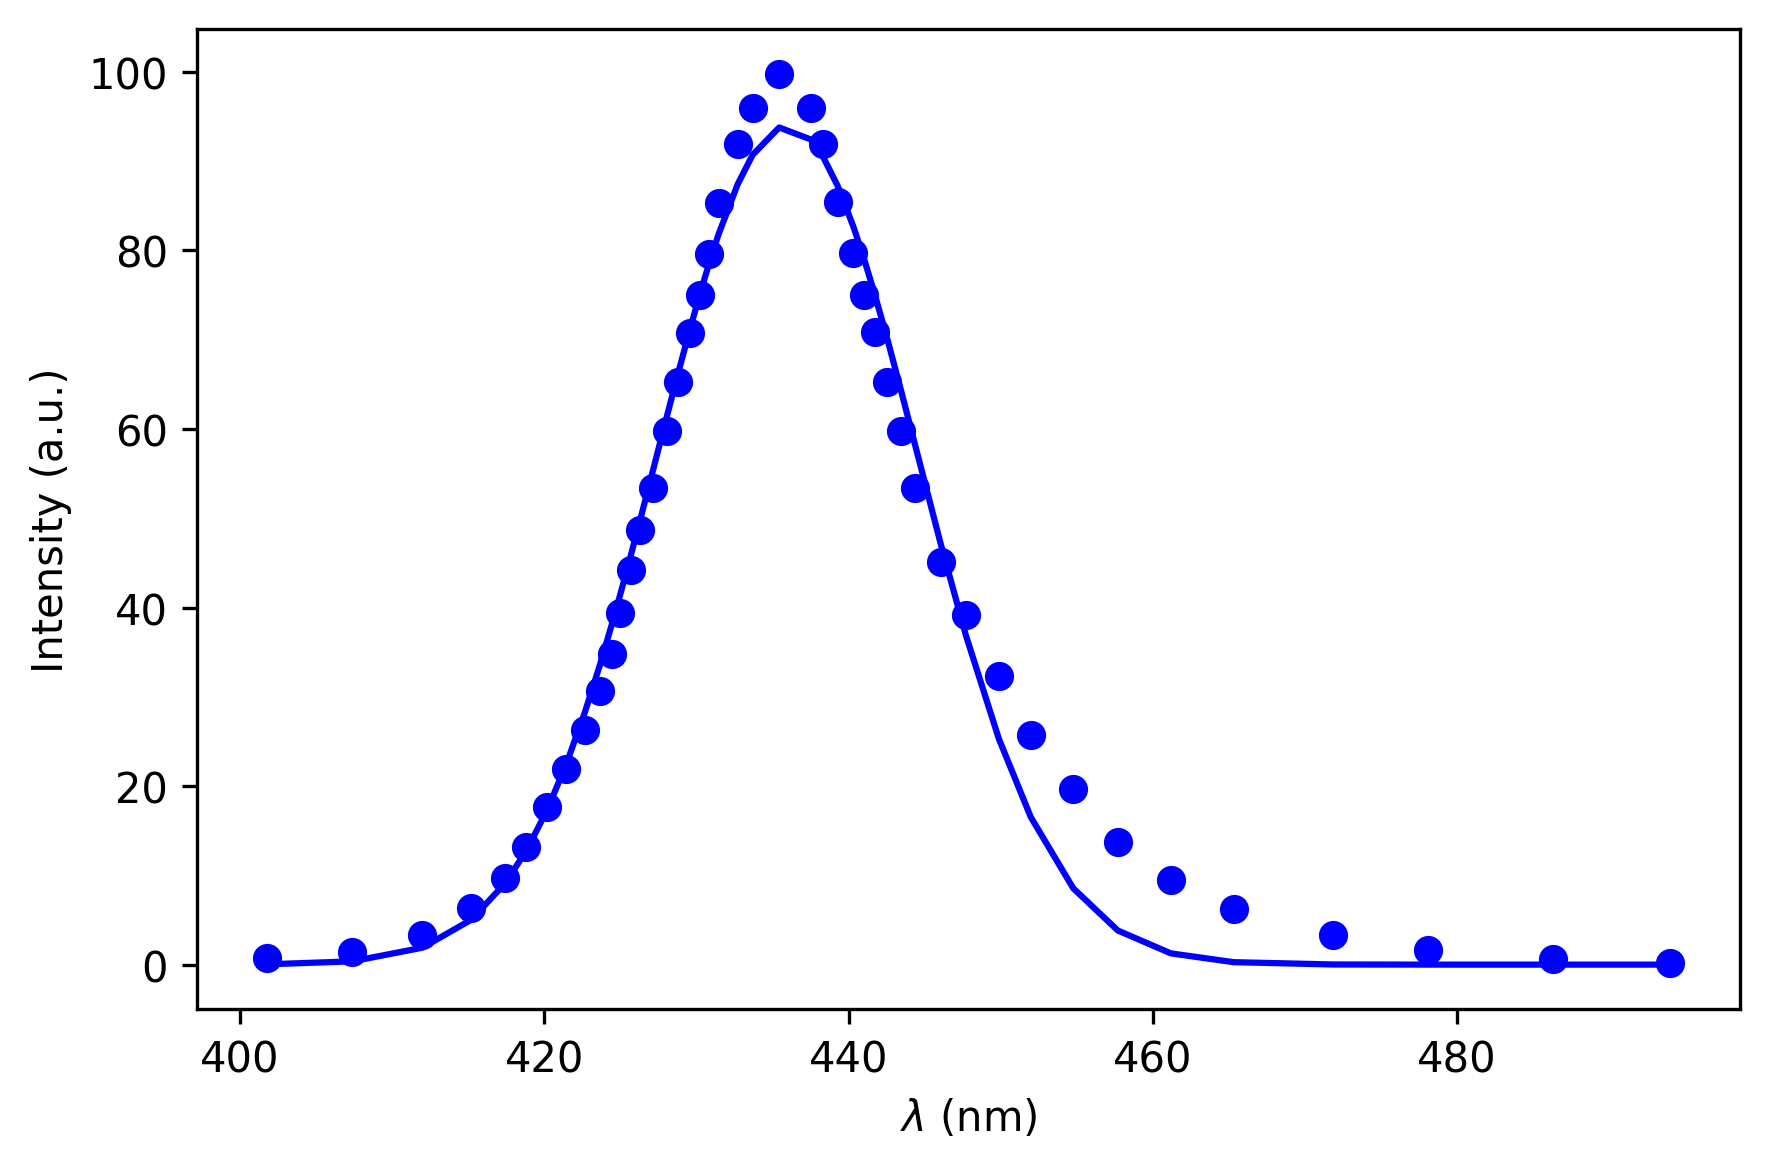

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(blue_spec['lambda'], blue_spec['intensity'], 'bo')
ax.plot(blue_spec['lambda'], spectrum_fit_res.best_fit, 'b-')

ax.set_xlabel(r'$\lambda$ (nm)')
ax.set_ylabel('Intensity (a.u.)')

fig.tight_layout();

Finally, we show the fit parameters, $\Gamma$, $A$, and $B$.

In [16]:
# optical parameters
L = 512 * pixel_size
NAo = 0.7
lambda0 = spectrum_fit_res.params["mu"].value * 1e-3
delta_lambda = spectrum_fit_res.params["sigma"].value * 1e-3

# limits
q_min = 2 * np.pi / L
q_max = 2 * np.pi * NAo / lambda0
gamma_0 = 1 / aa[0].tau[0]    # also, gamma_0 = frame_rate
gamma_T = 1 / aa[0].tau[-1]

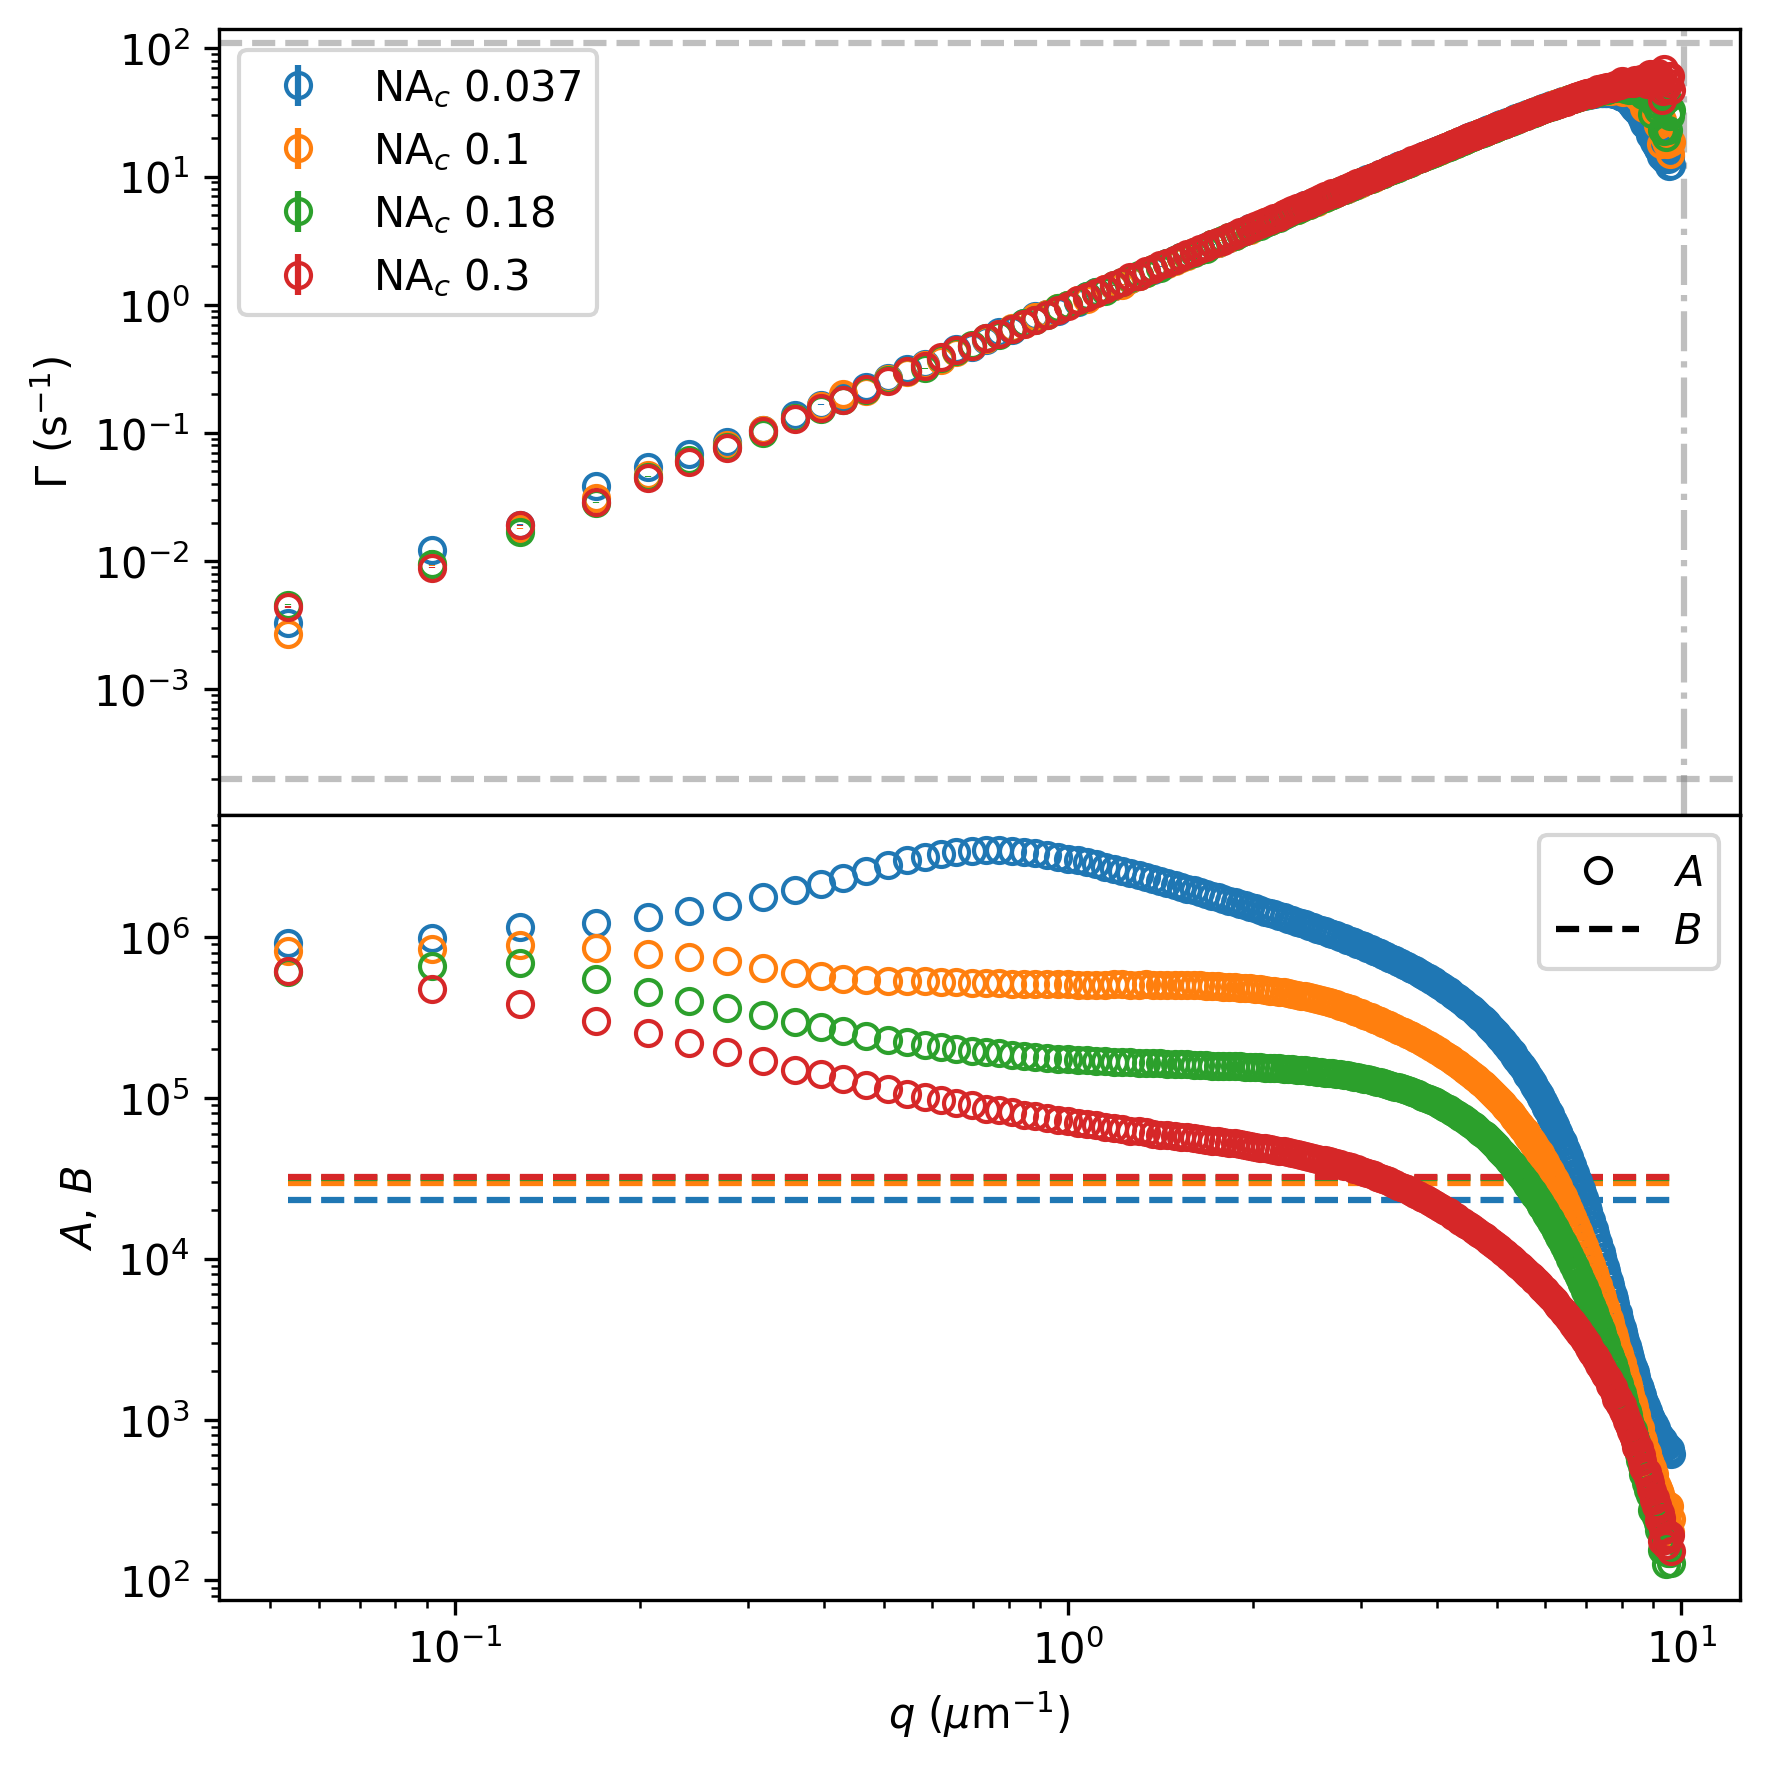

In [17]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot
for n, (fr, label) in enumerate(zip(fit_res, labels)):
    # filter only nan and non-successful fits
    tmp_df = fr[fr['success']].dropna()
    
    # display the full data (with transparency)
    axs[0].errorbar(
        tmp_df['k'],
        tmp_df['Gamma'],
        yerr=tmp_df['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    axs[1].errorbar(
        tmp_df['k'],
        tmp_df['A'],
        yerr=tmp_df['A_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
    )
    axs[1].plot(
        tmp_df['k'],
        np.full_like(tmp_df['B'], fill_value=tmp_df['B'].mean()),
        f'C{n}--',
    )

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].legend()
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none',
           color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')

# plot Gamma limits
axs[0].axhline(gamma_T, color='gray', linestyle='--', alpha=0.5)
axs[0].axhline(gamma_0, color='gray', linestyle='--', alpha=0.5)

# plot q limits
axs[0].axvline(x=q_max, color='gray', linestyle='-.', alpha=0.5)

fig.tight_layout();

The vertical dash-dotted lines in the upper panel are the $q_{\text{max}} = 2 \pi \mathrm{NA}_o / \lambda$ limit.
Reducing the condenser numerical aperture enhances the effect we saw in [tutorial3](../Tutorial_3-Image_windowing/tutorial3.ipynb).
As $\text{NA}_c$ decreases, the spatial coherence of the illumination increases.
The signal of the interference of the light diffused by the particle extends on a larger spatial scale.
Following the same reasoning we outlined in the third tutorial, this means that an apparently larger object is seen crossing the boundaries of the image.
The spurious contribution is visible also at smaller wave vectors.
In principle, we can suppress this effect by using image windowing as we did before.

We can again filter the fit results as we saw in the first tutorial.
We remove from all the datasets the values corresponding to wave vectors larger than 6.7 $\mu m^{-1}$.

In [18]:
fit_res_filtered = []

q_max = 6.7

for fr in fit_res:
    # remove non-succesful fits and nans
    tmp_df = fr[fr['success']].dropna()
    
    # filter q range
    tmp_df = tmp_df[(tmp_df['k'] <= q_max)]
    
    # append to list
    fit_res_filtered.append(tmp_df)

We plot again the filtered results

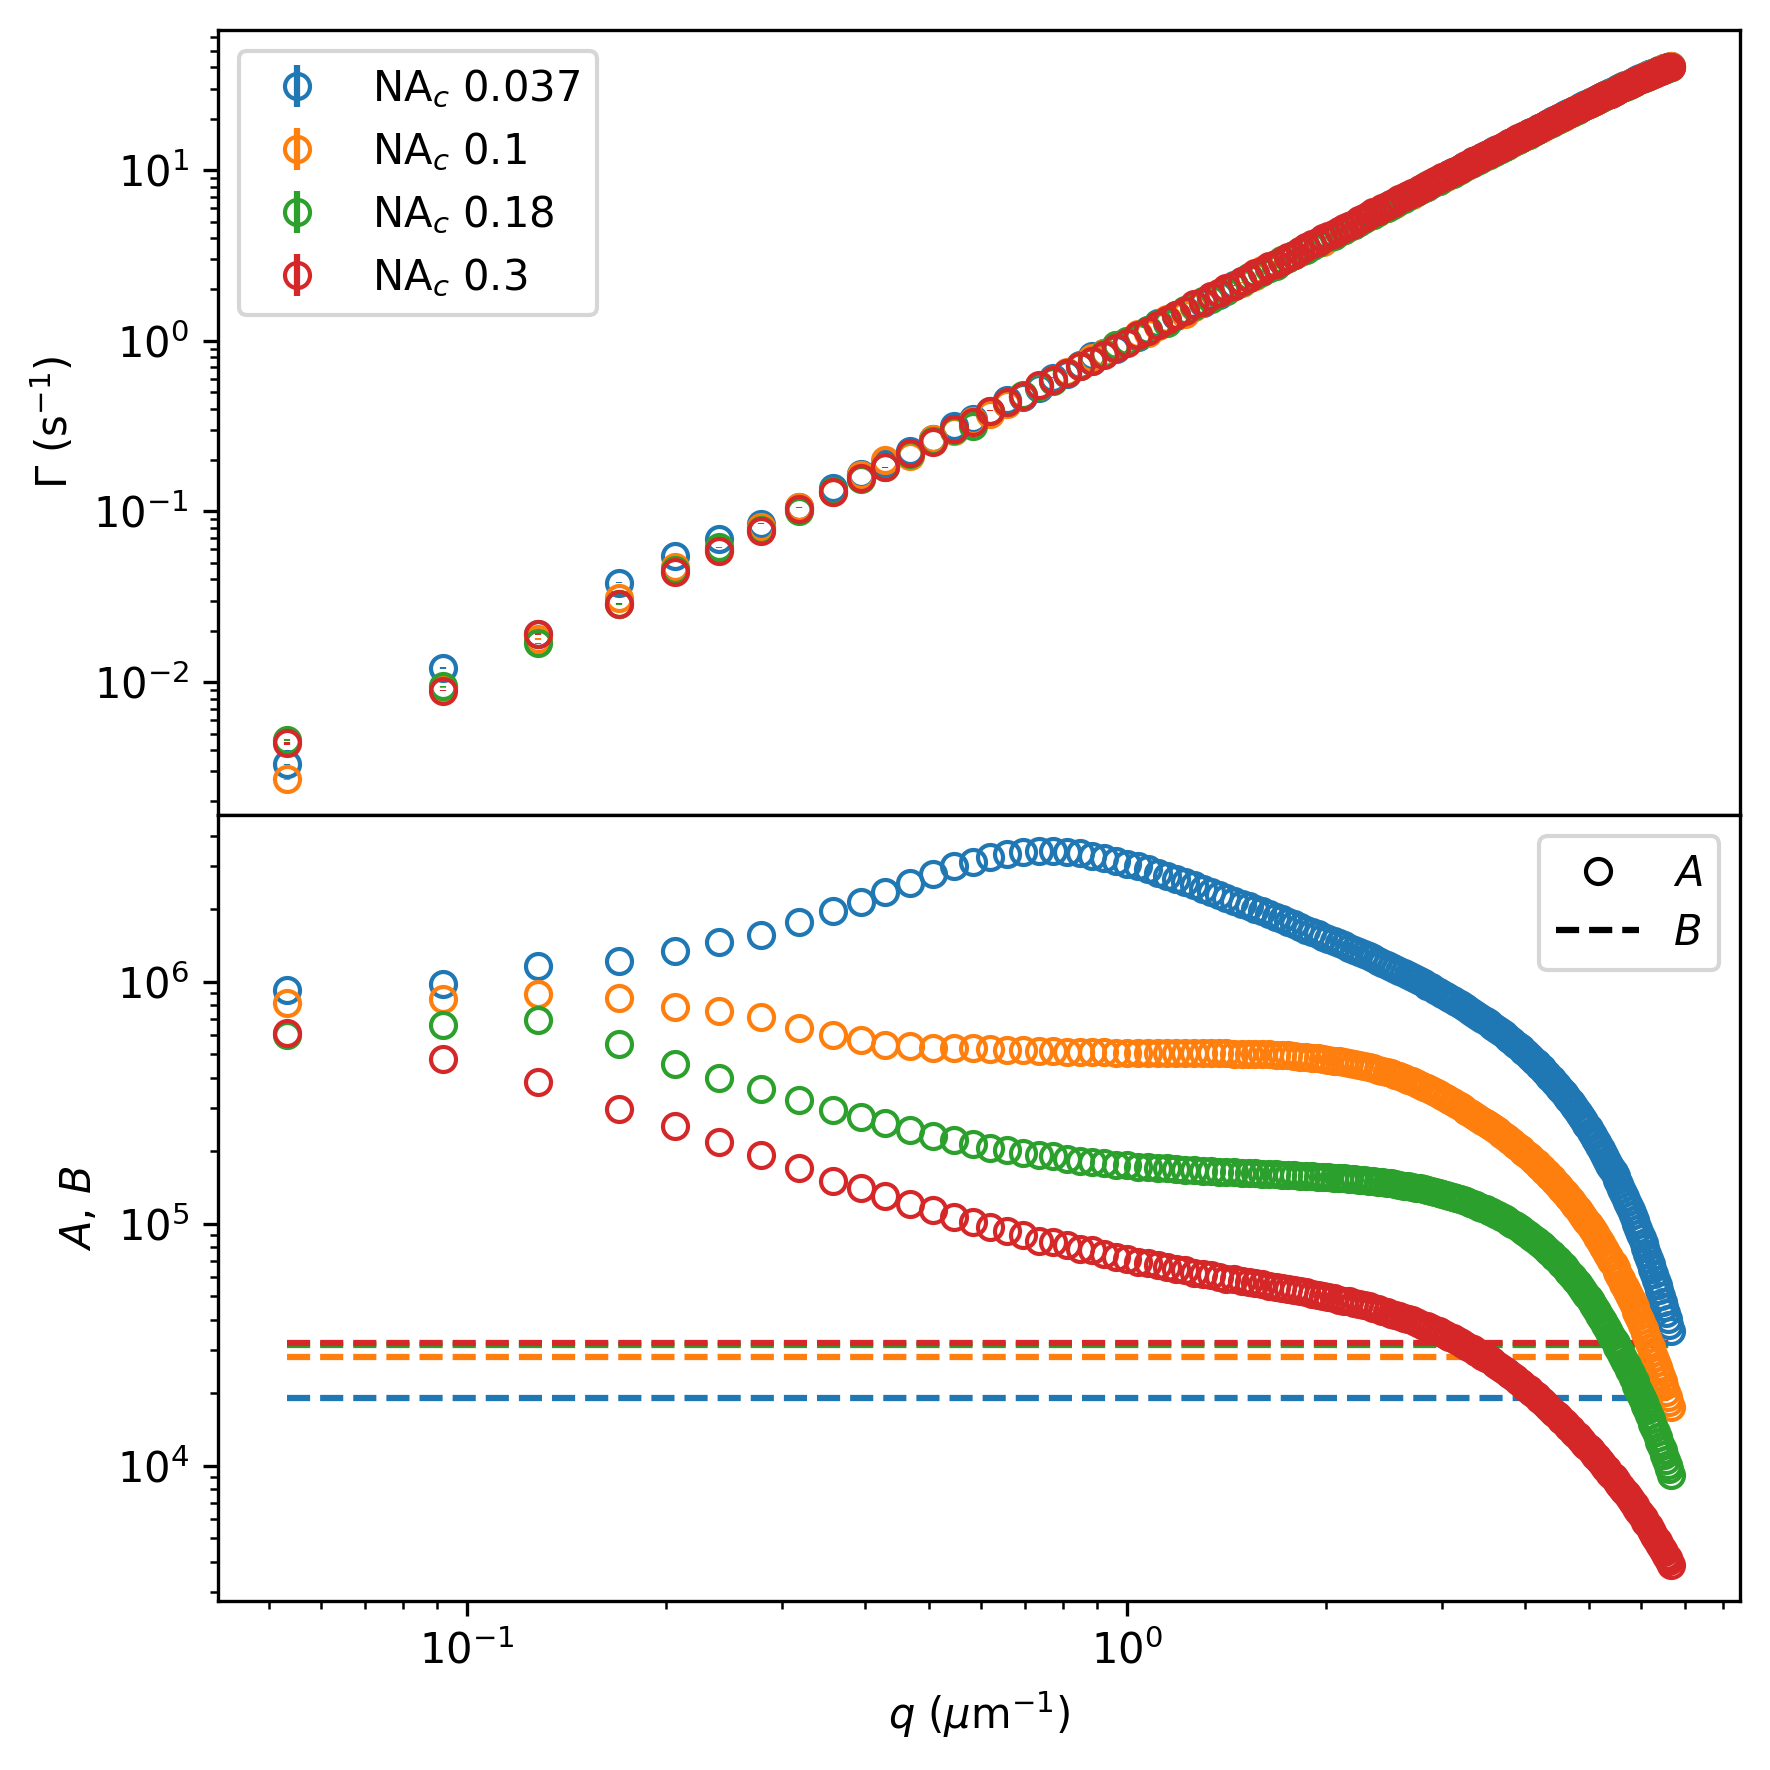

In [19]:
fig = plt.figure()
fig.set_figheight(1.5 * fig.get_figheight())
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True)

# plot
for n, (fr, label) in enumerate(zip(fit_res_filtered, labels)):
    axs[0].errorbar(
        fr['k'],
        fr['Gamma'],
        yerr=fr['Gamma_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
        label=label
    )
    axs[1].errorbar(
        fr['k'],
        fr['A'],
        yerr=fr['A_stderr'],
        fmt=f'C{n}o',
        markerfacecolor='none',
    )
    axs[1].plot(
        fr['k'],
        np.full_like(fr['B'], fill_value=fr['B'].mean()),
        f'C{n}--',
    )

# settings
axs[0].set_yscale('log')
axs[0].set_ylabel(r'$\Gamma$ (s$^{-1}$)')
axs[0].legend()
axs[1].set_xscale('log')
axs[1].set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
axs[1].set_yscale('log')
axs[1].set_ylabel(r'$A$, $B$')
custom_lines = [
    Line2D([0], [0], marker='o', linestyle='none', markerfacecolor='none',
           color='black', label=r'$A$'),
    Line2D([0], [0], linestyle='--', color='black', label=r'$B$'),
]
axs[1].legend(handles=custom_lines, labelspacing=0.4, loc='upper right')

fig.tight_layout();

## 3. Amplitude model

The amplitude term contains interesting information on the sample properties, which can be retrieved if the optical parameters of the setup are known (completely or partially).
The analytical formula reads:
$$
A(q) \propto \frac{C^2(q)}{\Delta q} \left[ (1+\alpha^2) - (1-\alpha^2) \exp(-(\bar{q}_z / \Delta q)^2 ) \right] ,
$$
where
$$
C^2 (q) = \frac{\exp\left[- \frac{(q/q_{\text{ro}})^2}{1 + (q/q_{\text{ro}})^2 (\Delta \lambda/\lambda_0)^2} \right]}{1 + (q/q_{\text{ro}})^2 (\Delta \lambda/\lambda_0)^2} ,
$$
$$
\bar{q}_z (q) = \frac{q^2}{2 k_0} \left[ 1 - 2M^2 - \frac{1}{\sigma_o^2} \left( \frac{q}{k_0} \right)^2 \left( \frac{\Delta \lambda}{\lambda_0} \right)^2 \right] ,
$$
and
$$
\Delta q^2 (q) = q^2 \left[ \sigma_c^2 + \frac{1}{4} \left( \frac{q}{k_0} \right)^2 \left( \frac{\Delta \lambda}{\lambda_0} \right)^2 \right] + \ell^{-2} .
$$
Here, $k_0=2\pi/\lambda_0$, $M=\sigma_c / \sigma_o$, where $\sigma_{c,o}=\text{NA}_{c,o}/2$, $q_{\text{ro}} = k_0 \sigma_o \sqrt{(1+2M^2)/(1+M^2)}$, and $\ell \approx l/\sqrt{2 \pi}$, where $l$ is the sample thickness.
Moreover, for objects that behave more as phase objects (which is expected in our case), $\alpha$ will be approximately equal to the phase delay between the scattered light and the transmitted beam.
The phase delay depends on the particle radius, the refractive index mismatch between the particles and the solvent, and the illumination wavelength.

The formula is valid for small $M$ and $\Delta \lambda / \lambda$.

The particles' material is polystyrene (refractive index $m_p = 1.586$).
The solvent refractive index can be estimated from the formula $m_s = 1.333 (1-c_{\text{gly}}) + 1.474 c_{\text{gly}} = 1.363$.
The particle radius (126 nm) and the illumination wavelength (436 nm) are also known.

We can determine then an estimate of the phase delay from the particles.

In [20]:
# compute the phase delay of the particle from Mie theory
import importlib

if importlib.util.find_spec("miepython"):
    import miepython

    R = 0.126   # particle radius in microns
    mp = 1.586  # particle refractive index
    ms = 1.363  # solvent refractive index
    m = mp / ms # normalized refractive index

    k = 2 * np.pi * ms / lambda0

    x = R * k

    mu = 1.0   # cos(0)

    s1, s2 = miepython.mie_S1_S2(m, x, mu)
    phase = np.pi / 2 - np.angle(s1)
    
    print(f'Phase computed from Mie : {phase:.4f} rad')
else:
    # To be sure we have the phase even without Mie
    # we copy the value outside the if clause
    phase = 0.24163512797082087    # rad

print(f'Phase delay is : {phase:.4f} rad')

Phase computed from Mie : 0.2416 rad
Phase delay is : 0.2416 rad


We can also use the amplitude curves we found from the fit (actually, from the static analysis because we fixed the amplitude and noise using the estimates) to obtain different parameters:
* the phase delay
* the condenser numerical apertures for the various cases.

We will compare these values with the ones we estimated.

To do so, we perform a global fit of the model to our data.
We can fix some of the parameters, such as $\lambda_0$ and $\Delta \lambda$, which we obtained from the nominal spectrum, and the objective numerical aperture.
We will leave free to vary, on top of the values that we listed above, also the sample thickness, which is just approximate in the model, and the proportionality factor.

**Note**: The analysis below does **NOT** consider the effect of the particle form factor.
Since the particle is relarively small, we expect the form factor not to play a relevant role in the signal we obtain (it is relatively flat over the $q$ range investigated).

Let's define the functions for the global fit.

In [21]:
from lmfit import Parameters, minimize, report_fit

# define the amplitude model
def A_model(x, a, NA_c, NA_o, l, lambda_0, delta_lambda, alpha):
    q = x   # just rename x to q for better comparison with formulas
    
    # derived quantities
    k0 = 2 * np.pi / lambda_0
    q_norm = q / k0
    
    sigma_c = NA_c / 2
    sigma_o = NA_o / 2
    M = sigma_c / sigma_o
    q_ro = k0 * sigma_o * np.sqrt((1 + 2 * M**2)/(1 + M**2))
    
    dl_norm = delta_lambda / lambda_0
    
    Sigma = 1 / l
    
    # final quantities
    qz = ( (k0 * q_norm**2 / 2) * \
          (1 - 2 * M**2 - (q_norm * dl_norm / sigma_o)**2) )
    
    dq = q * np.sqrt(sigma_c**2 + (q_norm * dl_norm / 2)**2)
    dq = np.sqrt(dq**2 + Sigma**2)
    
    den = 1 + (q / q_ro * dl_norm)**2
    C2 = np.exp(-(q / q_ro)**2 / den) / den
    
    return ( a * C2 / dq * \
            ((1 + alpha**2) - (1 - alpha**2) * np.exp(-(qz / dq)**2)) )

# define helper function for global fit
def A_dataset(params, n, x):
    # unpack parameters
    a = params[f'a_{n}']
    NA_c = params[f'NA_c_{n}']
    NA_o = params[f'NA_o']
    l = params['l']
    lambda_0 = params['lambda_0']
    delta_lambda = params['delta_lambda']
    alpha = params['alpha']
    return A_model(x, a, NA_c, NA_o, l, lambda_0, delta_lambda, alpha)


# define target function for global fit
def target(params, x, data, start_idx):
    '''Calculate total residual for fits of A to several data sets.'''
    resid = np.zeros_like(data)
    
    ndata = len(start_idx) - 1
    
    for n in range(ndata):
        start = start_idx[n]
        end = start_idx[n+1]
        resid[start:end] = data[start:end] - A_dataset(params, n,
                                                       x[start:end])
        
    return resid

Now, let's run our global fit routine.

In [22]:
# fit at fixed calculated phase and varying NAc
params = Parameters()

# the amplitude and the numerical aperture of the condenser
# are specific for each measurement
for n, NA in enumerate(NA_c):
    params.add(f'a_{n}', min=0.0, value=6e4)
    params.add(f'NA_c_{n}', min=0.0, max=0.5, value=NA, vary=True)

# add other parameters
params.add('NA_o', value=0.7, vary=False)
params.add('l', min=300/np.sqrt(2*np.pi)*0.2, max=300/np.sqrt(2*np.pi)*5,
           value=300/np.sqrt(2*np.pi), vary=True)
params.add('lambda_0', value=spectrum_fit_res.params["mu"].value / 1e3,
           vary=False)
params.add('delta_lambda',
           value=spectrum_fit_res.params["sigma"].value / 1e3, vary=False)
params.add('alpha', value=phase, vary=True)

# concatenate the fit results
x = np.empty(0)      # q
data = np.empty(0)   # A(q)
start_idx = [0]      # starting indices of the different datasets
for fr in fit_res_filtered:
    x = np.concatenate((x, fr.k))
    data = np.concatenate((data, fr.A))
    # for the moment, start_idx just contains the length of the datasets
    start_idx.append(len(fr))

# do cumulative sum to get the actual starting indices
start_idx = np.cumsum(start_idx)

# do global fit
A_fit = minimize(target, params, args=(x, data, start_idx))

We can display the fit results...

In [23]:
report_fit(A_fit.params)

[[Variables]]
    a_0:           59308.5496 +/- 806.639136 (1.36%) (init = 60000)
    NA_c_0:        0.03496852 +/- 4.4962e-04 (1.29%) (init = 0.0372)
    a_1:           60097.9826 +/- 1363.24106 (2.27%) (init = 60000)
    NA_c_1:        0.09975438 +/- 0.00119005 (1.19%) (init = 0.0993)
    a_2:           46644.7725 +/- 1680.57547 (3.60%) (init = 60000)
    NA_c_2:        0.14832796 +/- 0.00306224 (2.06%) (init = 0.179)
    a_3:           46183.1979 +/- 2483.81625 (5.38%) (init = 60000)
    NA_c_3:        0.25325658 +/- 0.01055254 (4.17%) (init = 0.3)
    NA_o:          0.7 (fixed)
    l:             134.059615 +/- 1.27917350 (0.95%) (init = 119.6827)
    lambda_0:      0.4359765 (fixed)
    delta_lambda:  0.008582652 (fixed)
    alpha:         0.26567939 +/- 0.00302064 (1.14%) (init = 0.2416351)
[[Correlations]] (unreported correlations are < 0.100)
    C(a_0, NA_c_0)    = 0.986
    C(a_1, NA_c_1)    = 0.920
    C(a_2, NA_c_2)    = 0.863
    C(l, alpha)       = -0.854
    C(a_3, NA_c_

...and plot the fit curves we obtained.

In [24]:
# plot fit results
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

for n, fr in enumerate(fit_res_filtered):
    # plot A
    ax.plot(fr.k, fr.A, f'C{n}o', markerfacecolor='none', label=labels[n])
    
    # plot A fit
    y_fit = A_dataset(A_fit.params, n, fr.k)
    ax.plot(fr.k, y_fit, f'C{n}-')
    
    # plot B
    ax.plot(fr.k, fr.B, f'C{n}--')
    
ax.set_xscale('log')
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_ylabel(r'$A$, $B$')
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0.1)
ax.legend()

fig.tight_layout()

The model very well describes the experimental data!
Moreover, the parameters are in line with what we estimated.
The phase delay from the fit is 0.266 rad, very close to the estimated value 0.242 rad.
The sample thickness is $134 \sqrt{2\pi} = 336 \, \mu m$.
The numerical apertures are 0.0350, 0.0998, 0.148, and 0.25, compared to our initial values of 0.0372, 0.0993, 0.179, and 0.3 (see below the plot).

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

NA_c_fit = [A_fit.params[f'NA_c_{n}'].value for n in range(4)]
NA_c_fit_err = [A_fit.params[f'NA_c_{n}'].stderr for n in range(4)]

ax.errorbar(NA_c, NA_c_fit, yerr=NA_c_fit_err, xerr=0.05*np.array(NA_c),
            fmt='o', markersize=6)
ax.plot([0]+NA_c, [0]+NA_c, 'k--')

ax.set_xlabel(r'$\mathrm{NA}_c^{(\mathrm{est})}$')
ax.set_ylabel(r'$\mathrm{NA}_c^{(\mathrm{fit})}$')

ax.set_xlim(xmin=0)
ax.set_ylim(ymin=0)

fig.tight_layout();

Before we conclude, it is instructive to investigate how the amplitude changes with the different parameters.

The parameters we use are:
* $\alpha = 0.242 \, \text{rad}$
* $\ell = 300 / \sqrt{2 \pi} = 120 \, \mu m$
* $\text{NA}_o = 0.7$
* $\text{NA}_c = 0.03$
* $\lambda_0 = 0.436 \, \mu m$
* $\Delta \lambda = 0.008 \, \mu m$

We will vary one parameter at a time in a limited predefined range of values.

In [26]:
# define reference parameters
q = np.logspace(-1, 1, num=50)

NA_c_ref = A_fit.params['NA_c_0'].value
NA_o_ref = 0.7
ell_ref = A_fit.params['l'].value * np.sqrt(2 * np.pi)
lambda_0_ref = 0.436
delta_lambda_ref = 0.008
alpha_ref = A_fit.params['alpha'].value

### Condenser numerical aperture

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# define NAc for plot
NA_c_plot = np.sort(np.array([0.01, 0.1, 0.3, NA_c_ref]))

# --- vary NAc ---
for nac in NA_c_plot:
    if nac == NA_c_ref:
        ax.plot(q, A_model(q, 1, nac, NA_o_ref, 
                           ell_ref / np.sqrt(2 * np.pi), lambda_0_ref,
                           delta_lambda_ref, alpha_ref),
                'k--', label=f'{nac:.3f}')
    else:
        ax.plot(q, A_model(q, 1, nac, NA_o_ref,
                           ell_ref / np.sqrt(2 * np.pi), lambda_0_ref,
                           delta_lambda_ref, alpha_ref),
                '-', label=f'{nac}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_ylabel(r'$A$')
ax.set_xlim(np.min(q), np.max(q))
ax.legend(title=r'NA$_c$')

fig.tight_layout();

### Objective numerical aperture

In [28]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# define NAo for plot
NA_o_plot = np.sort(np.array([0.2, 0.5, 1.49, NA_o_ref]))

# --- vary NAo ---
for nao in NA_o_plot:
    if nao == NA_o_ref:
        ax.plot(q, A_model(q, 1, NA_c_ref, nao,
                           ell_ref / np.sqrt(2 * np.pi), lambda_0_ref,
                           delta_lambda_ref, alpha_ref),
                'k--', label=f'{nao:.2f}')
    else:
        ax.plot(q, A_model(q, 1, NA_c_ref, nao,
                           ell_ref / np.sqrt(2 * np.pi), lambda_0_ref,
                           delta_lambda_ref, alpha_ref),
                '-', label=f'{nao}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(ymin=1e-3)
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_ylabel(r'$A$')
ax.set_xlim(np.min(q), np.max(q))
ax.legend(title=r'NA$_o$')

fig.tight_layout();

### Sample thickness

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# define ell for plot
ell_plot = np.sort(np.array([30, 100, np.inf, ell_ref]))

# --- vary ell ---
for ell in ell_plot:
    if ell == ell_ref:
        ax.plot(q, A_model(q, 1, NA_c_ref, NA_o_ref,
                           ell / np.sqrt(2 * np.pi), lambda_0_ref,
                           delta_lambda_ref, alpha_ref),
                'k--', label=f'{ell:.0f}')
    else:
        ax.plot(q, A_model(q, 1, NA_c_ref, NA_o_ref,
                           ell / np.sqrt(2 * np.pi), lambda_0_ref,
                           delta_lambda_ref, alpha_ref),
                '-',
                label=f'{ell:.0f}' if not np.isinf(ell) else r'$\infty$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_ylabel(r'$A$')
ax.set_xlim(np.min(q), np.max(q))
ax.legend(title=r'$l$ ($\mu$m)')

fig.tight_layout();

### Illumination wavelength

In [30]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# define lambda0 for plot
lambda_0_plot = np.sort(np.array([0.532, 0.589, 0.632, lambda_0_ref]))

# --- vary lambda_0 ---
for l0 in lambda_0_plot:
    if l0 == lambda_0_ref:
        ax.plot(q, A_model(q, 1, NA_c_ref, NA_o_ref,
                           ell_ref / np.sqrt(2 * np.pi), l0,
                           delta_lambda_ref, alpha_ref),
                'k--', label=f'{l0*1e3:.0f}')
    else:
        ax.plot(q, A_model(q, 1, NA_c_ref, NA_o_ref,
                           ell_ref / np.sqrt(2 * np.pi), l0,
                           delta_lambda_ref, alpha_ref),
                '-', label=f'{l0*1e3:.0f}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_ylabel(r'$A$')
ax.set_xlim(np.min(q), np.max(q))
ax.legend(title=r'$\lambda_0$ (nm)')

fig.tight_layout();

### Illumination wavelength spread

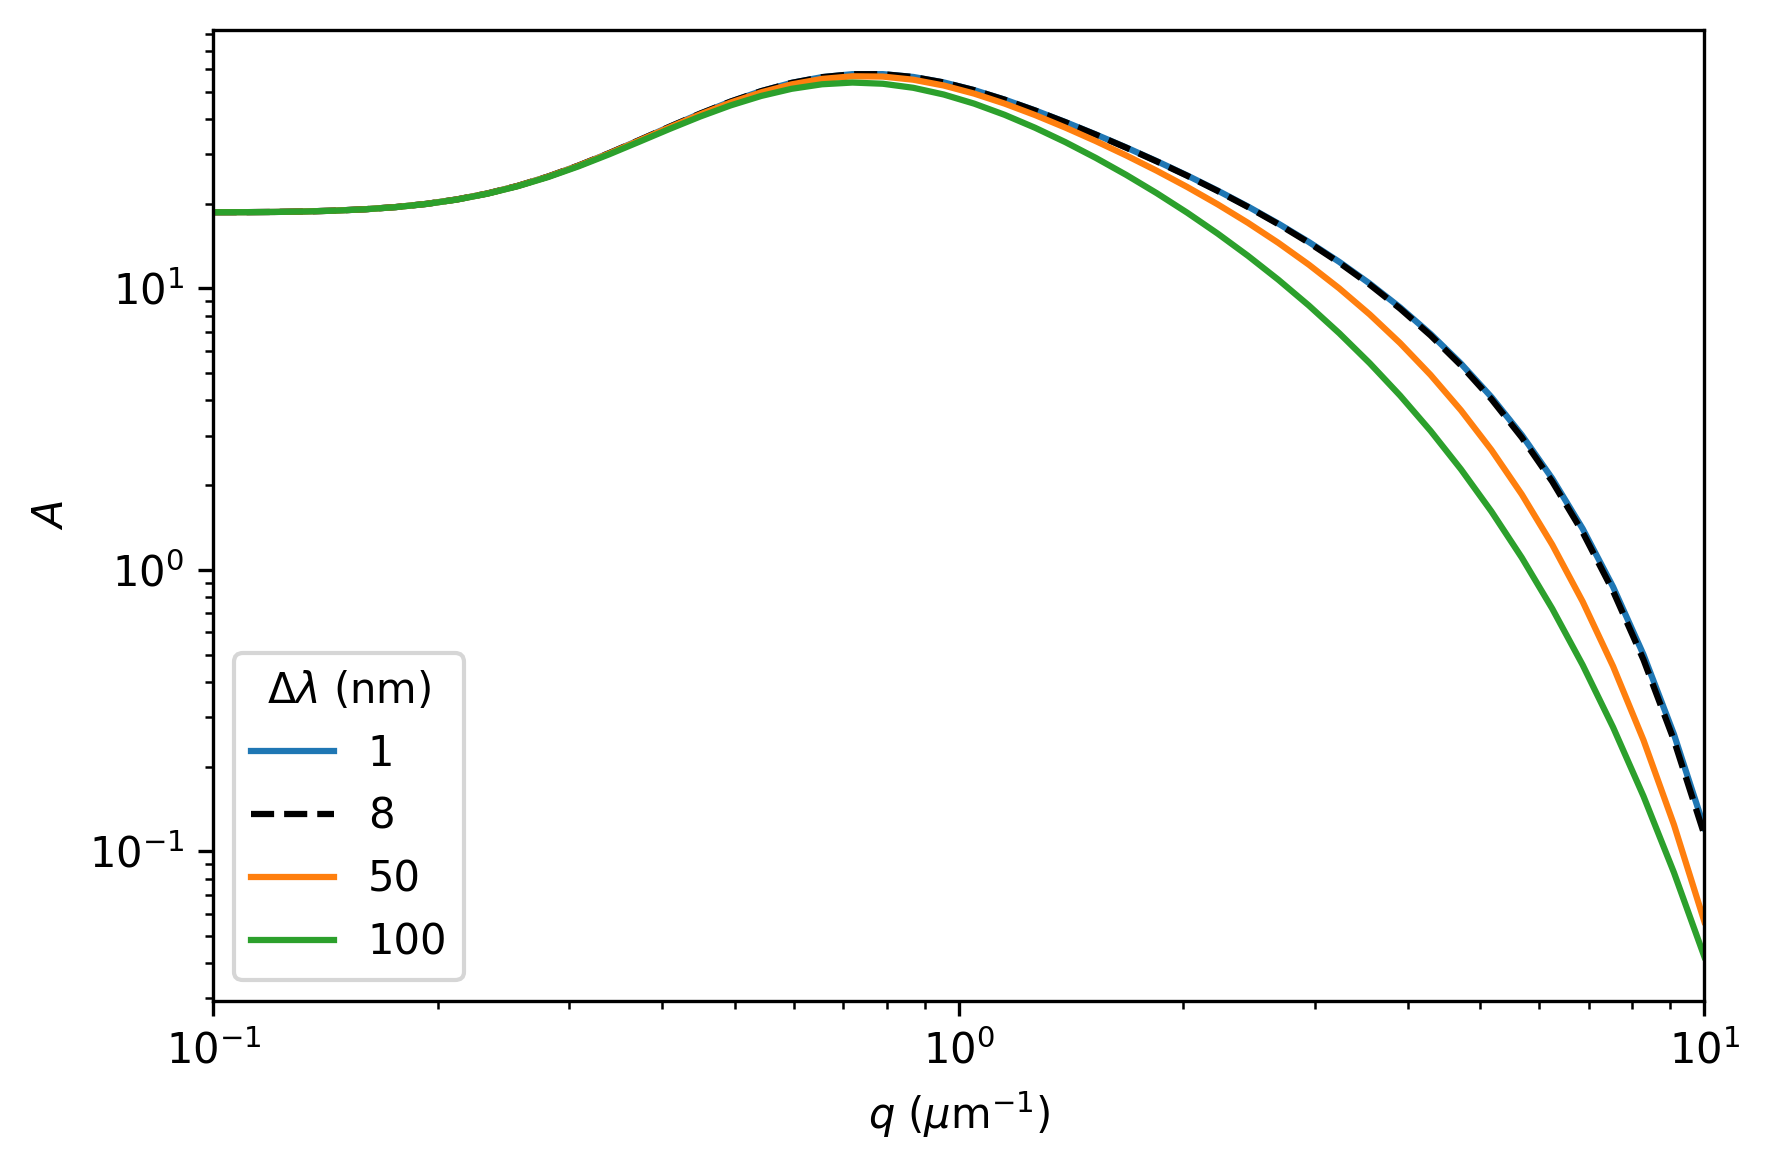

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# define delta_lambda for plot
delta_lambda_plot = np.sort(np.array([0.001, 0.05, 0.1, delta_lambda_ref]))

# --- vary lambda_0 ---
for dl in delta_lambda_plot:
    if dl == delta_lambda_ref:
        ax.plot(q, A_model(q, 1, NA_c_ref, NA_o_ref,
                           ell_ref / np.sqrt(2 * np.pi), lambda_0_ref, dl,
                           alpha_ref),
                'k--', label=f'{dl*1e3:.0f}')
    else:
        ax.plot(q, A_model(q, 1, NA_c_ref, NA_o_ref,
                           ell_ref / np.sqrt(2 * np.pi), lambda_0_ref, dl,
                           alpha_ref),
                '-', label=f'{dl*1e3:.0f}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_ylabel(r'$A$')
ax.set_xlim(np.min(q), np.max(q))
ax.legend(title=r'$\Delta \lambda$ (nm)')

fig.tight_layout();

### Phase factor

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# define alpha for plot
alpha_plot = np.sort(np.array([0.01, 0.1, 0.5, alpha_ref]))

# --- vary alpha ---
for a in alpha_plot:
    if a == alpha_ref:
        ax.plot(q, A_model(q, 1, NA_c_ref, NA_o_ref,
                           ell_ref / np.sqrt(2 * np.pi), lambda_0_ref,
                           delta_lambda_ref, a),
                'k--', label=f'{a:.3f}')
    else:
        ax.plot(q, A_model(q, 1, NA_c_ref, NA_o_ref,
                           ell_ref / np.sqrt(2 * np.pi), lambda_0_ref,
                           delta_lambda_ref, a),
                '-', label=f'{a}')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
ax.set_ylabel(r'$A$')
ax.set_xlim(np.min(q), np.max(q))
ax.legend(title=r'$\alpha$ (rad)')

fig.tight_layout();

### What do we learn?

From the above plots of the amplitude, we understand the following:
* Some experimental parameters can be estimated from the amplitude of the structure function
* The phase delay $\alpha$ mainly affects the plateau at low $q$
* As the numerical aperture of the condenser is increased, the signal is largely suppressed
* As the numerical aperture of the objective is increased, the signal at large $q$ is enhanced (the setup is actually able to collect this signal)
* As the sample thickness is increased, the signal increases and the maximum shifts to lower $q$. However, if the phase is the experimental parameter of interest, it makes sense to choose a relatively small thickness to extend the plateau at low $q$.
* The contribute of $\lambda_0$ and $\Delta \lambda$ is relatively small. By increasing the former, the signal is slightly enhanced at low $q$ and suppressed at high $q$. By increasing $\Delta \lambda$, the signal is suppressed at high $q$.

# (\*) Figures for paper

In [33]:
save_figures = False

In [34]:
if save_figures:
    # --- imports ---
    import scienceplots

    plt.style.use(['science', 'nature', 'vibrant'])
    mpl.rcParams['lines.markeredgewidth'] = 0.7
    
    # create FIGS directory
    os.makedirs('FIGS', exist_ok=True)

In [35]:
if save_figures:
    # --- save f(q, dt) fit comparison ---
    fig = plt.figure()
    fig.set_figheight((len(aa) / 2) * fig.get_figheight())
    gs = fig.add_gridspec(len(aa), hspace=0)
    axs = gs.subplots(sharex=True)

    idx_min = np.argwhere(aa[0].k >= k_min)[0,0]
    idx_max = np.argwhere(aa[0].k <= k_max)[-1,0]
    k_list = np.linspace(idx_min, idx_max, num=10, dtype=int)

    cspace = color_space(len(k_list))

    # plot curves
    for ax, a, ar, fr, mr, l in zip(axs, aa, aa_resampled, fit_res,
                                    model_res, labels):
        for k_idx, c in zip(k_list, cspace):
            # calculate intermediate scattering function
            fqt = 1 - (ar.data[k_idx] - fr['B'][k_idx]) / fr['A'][k_idx]
            fqt_fit = ( 1 - \
                       (mr[k_idx].best_fit - fr['B'][k_idx]) / \
                       fr['A'][k_idx] )
    
            # plot
            ax.plot(ar.tau, fqt, '.', color=c)
            ax.plot(a.tau, fqt_fit, '-', color=c)
        
            # misc
            ax.set_ylabel(r'$f(\Delta t; q)$')
            ax.set_ylim(-0.1, 1.1)
            # label
            at = AnchoredText(l, prop=dict(size=10), frameon=True,
                              loc='upper right')
            ax.add_artist(at)
            # custom legend
            custom_lines = [
                Line2D([0], [0], marker='.', linestyle='none',
                       color='black', label='data'),
                Line2D([0], [0], linestyle='-', color='black', label='fit'),
            ]
            ax.legend(handles=custom_lines, labelspacing=0.4,
                      loc='center right')
        
    axs[-1].set_xscale('log')
    axs[-1].set_xlabel(r'$\Delta t$ (s)')

    fig.tight_layout()
    
    fig.savefig('FIGS/fqt.pdf', dpi=600)

In [36]:
if save_figures:
    # --- save amplitude fit ---
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    for n, fr in enumerate(fit_res_filtered):
        # plot A
        ax.plot(fr.k, fr.A, f'C{n}o', markerfacecolor='none',
                label=labels[n])
    
        # plot A fit
        y_fit = A_dataset(A_fit.params, n, fr.k)
        ax.plot(fr.k, y_fit, f'C{n}-')
    
        # plot B
        ax.plot(fr.k, fr.B, f'C{n}--')
        
    # add the lamp spectrum as an inset
    axins = ax.inset_axes([0.7, 0.62, 0.28, 0.35])
    axins.plot(blue_spec['lambda'], blue_spec['intensity'], 'bo',
               markerfacecolor='none', alpha=0.5)
    axins.plot(blue_spec['lambda'], spectrum_fit_res.best_fit, 'k-')

    axins.set_xlabel(r'$\lambda$ (nm)')
    axins.set_ylabel('Int. (a.u.)')
    
    ax.set_xscale('log')
    ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
    ax.set_ylabel(r'$A$, $B$')
    ax.set_ylim(ymin=0)
    ax.set_xlim(xmin=0.1, xmax=10)
    ax.legend(loc='upper left')

    fig.tight_layout()
    
    fig.savefig('FIGS/A_fit.pdf', dpi=600)

In [37]:
if save_figures:
    # --- save numerical aperture ---
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    NA_c_fit = [A_fit.params[f'NA_c_{n}'].value for n in range(4)]
    NA_c_fit_err = [A_fit.params[f'NA_c_{n}'].stderr for n in range(4)]

    ax.errorbar(NA_c, NA_c_fit, yerr=NA_c_fit_err, xerr=0.05*np.array(NA_c),
                fmt='o', markersize=6)
    ax.plot([0]+NA_c, [0]+NA_c, 'k--')

    ax.set_xlabel(r'$\mathrm{NA}_c^{(\mathrm{est})}$')
    ax.set_ylabel(r'$\mathrm{NA}_c^{(\mathrm{fit})}$')

    ax.set_xlim(xmin=0)
    ax.set_ylim(ymin=0)

    fig.tight_layout()
    
    fig.savefig('FIGS/NAc_fit.pdf', dpi=600)

In [38]:
if save_figures:
    # --- save A model vs parameters ---
    fig = plt.figure()
    fig.set_figheight(1.5 * fig.get_figheight())
    fig.set_figwidth(2 * fig.get_figwidth())
    gs = fig.add_gridspec(ncols=3, nrows=2)
    axs = gs.subplots()
    
    legend_titles = [
        r'NA$_c$', r'NA$_o$', r'$l$ ($\mu$m)',
        r'$\lambda_0$ (nm)', r'$\Delta \lambda$ (nm)', r'$\alpha$ (rad)'
    ]
    
    # vary NAc
    for nac in NA_c_plot:
        if nac == NA_c_ref:
            axs[0,0].plot(
                q,
                A_model(q, 1, nac, NA_o_ref, ell_ref / np.sqrt(2 * np.pi),
                        lambda_0_ref, delta_lambda_ref, alpha_ref),
                'k--', 
                label=f'{nac:.3f}'
            )
        else:
            axs[0,0].plot(
                q,
                A_model(q, 1, nac, NA_o_ref, ell_ref / np.sqrt(2 * np.pi),
                        lambda_0_ref, delta_lambda_ref, alpha_ref),
                '-',
                label=f'{nac}'
            )
    
    # vary NAo
    for nao in NA_o_plot:
        if nao == NA_o_ref:
            axs[0,1].plot(
                q,
                A_model(q, 1, NA_c_ref, nao, ell_ref / np.sqrt(2 * np.pi),
                        lambda_0_ref, delta_lambda_ref, alpha_ref),
                'k--',
                label=f'{nao:.2f}'
            )
        else:
            axs[0,1].plot(
                q,
                A_model(q, 1, NA_c_ref, nao, ell_ref / np.sqrt(2 * np.pi),
                        lambda_0_ref, delta_lambda_ref, alpha_ref),
                '-',
                label=f'{nao}'
            )
    
    # vary l
    for ell in ell_plot:
        if ell == ell_ref:
            axs[0,2].plot(
                q,
                A_model(q, 1, NA_c_ref, NA_o_ref, ell / np.sqrt(2 * np.pi),
                        lambda_0_ref, delta_lambda_ref, alpha_ref),
                'k--',
                label=f'{ell:.0f}'
            )
        else:
            axs[0,2].plot(
                q,
                A_model(q, 1, NA_c_ref, NA_o_ref, ell / np.sqrt(2 * np.pi),
                        lambda_0_ref, delta_lambda_ref, alpha_ref),
                '-',
                label=f'{ell:.0f}' if not np.isinf(ell) else r'$\infty$'
            )
    
    # vary lambda_0
    for l0 in lambda_0_plot:
        if l0 == lambda_0_ref:
            axs[1,0].plot(
                q,
                A_model(q, 1, NA_c_ref, NA_o_ref, ell_ref / np.sqrt(2 * np.pi),
                        l0, delta_lambda_ref, alpha_ref),
                'k--',
                label=f'{l0*1e3:.0f}'
            )
        else:
            axs[1,0].plot(
                q,
                A_model(q, 1, NA_c_ref, NA_o_ref, ell_ref / np.sqrt(2 * np.pi),
                        l0, delta_lambda_ref, alpha_ref),
                '-',
                label=f'{l0*1e3:.0f}'
            )
    
    # vary delta_lambda
    for dl in delta_lambda_plot:
        if dl == delta_lambda_ref:
            axs[1,1].plot(
                q,
                A_model(q, 1, NA_c_ref, NA_o_ref, ell_ref / np.sqrt(2 * np.pi), 
                        lambda_0_ref, dl, alpha_ref),
                'k--',
                label=f'{dl*1e3:.0f}'
            )
        else:
            axs[1,1].plot(
                q,
                A_model(q, 1, NA_c_ref, NA_o_ref, ell_ref / np.sqrt(2 * np.pi),
                        lambda_0_ref, dl, alpha_ref),
                '-',
                label=f'{dl*1e3:.0f}'
            )
    
    # vary alpha
    for a in alpha_plot:
        if a == alpha_ref:
            axs[1,2].plot(
                q,
                A_model(q, 1, NA_c_ref, NA_o_ref, ell_ref / np.sqrt(2 * np.pi),
                        lambda_0_ref, delta_lambda_ref, a),
                'k--',
                label=f'{a:.3f}'
            )
        else:
            axs[1,2].plot(
                q,
                A_model(q, 1, NA_c_ref, NA_o_ref, ell_ref / np.sqrt(2 * np.pi),
                        lambda_0_ref, delta_lambda_ref, a),
                '-',
                label=f'{a}'
            )
    
    # plot panel label   
    at = [
        AnchoredText(f'{plabel})', prop=dict(size=10), frameon=False,
                     loc='upper right') for plabel in ['a', 'b', 'c',
                                                       'd', 'e', 'f']
    ]
    
    for n, (ax, lt, _at) in enumerate(zip(axs.flatten(),
                                          legend_titles, at)):
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel(r'$q$ ($\mu$m$^{-1}$)')
        ax.set_ylabel(r'$A$')
        ax.set_xlim(np.min(q), np.max(q))
        if n==1:
            ax.set_ylim(ymin=1e-2)
        if n==2:
            ax.set_ylim(ymin=2e-2)
        ax.set_ylim(ymax=2e2)
        if n==2:
            ax.legend(title=lt, loc='lower right')
        else:
            ax.legend(title=lt)
        ax.add_artist(_at)
        
    fig.tight_layout()
    
    fig.savefig('FIGS/A_model_vs_parameters.pdf', dpi=600)